In [1]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
import time
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Send a request to the Singapore Government's 'Carpark Availability' API
response = requests.get('https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-08-12T06%3A45%3A13')
parking_availability = response.json()['items'][0]
timestamp = parking_availability['timestamp']
df = pd.DataFrame(parking_availability['carpark_data'])
info_df = pd.read_csv('hdb-carpark-information.csv')

In [3]:
# seperate update_datetime into year-month.....
# df['year'] = df['update_datetime'].map(lambda date: dt.datetime.strptime(date,'20%y-%m-%dT%H:%M:%S').year)
# df['month'] = df['update_datetime'].map(lambda date: dt.datetime.strptime(date,'20%y-%m-%dT%H:%M:%S').month)
# df['day'] = df['update_datetime'].map(lambda date: dt.datetime.strptime(date,'20%y-%m-%dT%H:%M:%S').day)
# df['hour'] = df['update_datetime'].map(lambda date: dt.datetime.strptime(date,'20%y-%m-%dT%H:%M:%S').hour)
# df['minute'] = df['update_datetime'].map(lambda date: dt.datetime.strptime(date,'20%y-%m-%dT%H:%M:%S').minute)
# df['second'] = df['update_datetime'].map(lambda date: dt.datetime.strptime(date,'20%y-%m-%dT%H:%M:%S').second)
# Seperate info into arrays, as pandas isn't seperating them properly
total_lots = []
lot_type = []
lots_available = []
for carpark_info in parking_availability['carpark_data']:
    total_lots.append(carpark_info['carpark_info'][0]['total_lots'])
    lot_type.append(carpark_info['carpark_info'][0]['lot_type'])
    lots_available.append(carpark_info['carpark_info'][0]['lots_available'])

In [3]:
# Add the new columns and delete the unneeded one
df['total_lots'] = total_lots
df['lot_type'] = lot_type
df['lots_available'] = lots_available
df = df.drop(['carpark_info'], axis=1)
df = pd.merge(df, info_df, left_on=['carpark_number'], right_on=['car_park_no']).drop(['car_park_no'], axis=1)

NameError: name 'total_lots' is not defined

In [ ]:
df.head()

Some info about the data:

    1. No information about lot_type in the website, but it seems any carpark which does not have a lot_type of 'C' seems to not have real-time data, or 'Y' and 'H' might be for other vehicles.
    
    2. the x_coord and y_coord seem to be based on HBD data, and as such, the longitude and latitude must be gotten using the address instead of those
    
    3. Around 1750 update within at most 15 minutes (around 1400 of those update within at most 5 minutes) when going back a year (tested with 2019-08-12T20:45:13), number falls down to 1550-ish when going as far back as 2018, probably because there are less total parking areas
    
Column Information:
    

In [8]:
# Find out approximately how many have been updated in the last 15 minutes
# So only those can be used, rather than ones that are not being updated very frequently
df[df['update_datetime'].str.contains('2019-08-12T06:4')].count()

carpark_number            1597
update_datetime           1597
total_lots                1597
lot_type                  1597
lots_available            1597
address                   1597
x_coord                   1597
y_coord                   1597
car_park_type             1597
type_of_parking_system    1597
short_term_parking        1597
free_parking              1597
night_parking             1597
car_park_decks            1597
gantry_height             1597
car_park_basement         1597
dtype: int64

In [3]:
start_date = dt.datetime.fromtimestamp(1573934430)
end_date = dt.datetime.fromtimestamp(1605729630)
start_date_time = start_date.strftime('%y-%m-%dT%H:%M:%S')
end_date_time = end_date.strftime('%y-%m-%dT%H:%M:%S')

In [ ]:
# Getting all the dataframes
date = dt.datetime(year=2019, month=11, day=17, hour=1, minute=5, second=30)
n_iterations = 0
df_list = []
while(date != end_date):
    try:
        request_string = 'https://api.data.gov.sg/v1/transport/carpark-availability?date_time=%s' % (date.strftime('20%y-%m-%dT%H:%M:%S'))
        print(request_string)
        response = requests.get(request_string)
        parking_availability = response.json()['items'][0]
        timestamp = parking_availability['timestamp']
        df = pd.DataFrame(parking_availability['carpark_data'])
        total_lots = []
        lot_type = []
        lots_available = []
        for carpark_info in parking_availability['carpark_data']:
            total_lots.append(carpark_info['carpark_info'][0]['total_lots'])
            lot_type.append(carpark_info['carpark_info'][0]['lot_type'])
            lots_available.append(carpark_info['carpark_info'][0]['lots_available'])

        # Add year-month-day-hour-minutes-seconds columns
        df['year'] = date.year
        df['month'] = date.month
        df['day'] = date.day
        df['hour'] = date.hour
        df['minute'] = date.minute
        df['second'] = date.second
        # Add the new columns and delete the unneeded one
        df['total_lots'] = total_lots
        df['lot_type'] = lot_type
        df['lots_available'] = lots_available
        df = df.drop(['carpark_info'], axis=1)
        df_list.append(df)
        print('date: ', date)
        print('count: ', df['carpark_number'].count(),'\n')
        n_iterations += 1
        date = date + dt.timedelta(minutes=15)
        if(n_iterations == 2880):
            break
    except:
        date = date + dt.timedelta(minutes=1)
        print('retrying!')
n_iterations

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T01:05:30
date:  2019-11-17 01:05:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T01:20:30
retrying!
https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T01:21:30
date:  2019-11-17 01:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T01:36:30
date:  2019-11-17 01:36:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T01:51:30
date:  2019-11-17 01:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T02:06:30
date:  2019-11-17 02:06:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T02:21:30
date:  2019-11-17 02:21:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T02:36:30
date:  2019-11-17 02:36:30
count: 

date:  2019-11-17 16:36:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T16:51:30
date:  2019-11-17 16:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T17:06:30
date:  2019-11-17 17:06:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T17:21:30
date:  2019-11-17 17:21:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T17:36:30
date:  2019-11-17 17:36:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T17:51:30
date:  2019-11-17 17:51:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T18:06:30
date:  2019-11-17 18:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-17T18:21:30
date:  2019-11-17 18:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-18 08:36:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-18T08:51:30
date:  2019-11-18 08:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-18T09:06:30
date:  2019-11-18 09:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-18T09:21:30
date:  2019-11-18 09:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-18T09:36:30
date:  2019-11-18 09:36:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-18T09:51:30
date:  2019-11-18 09:51:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-18T10:06:30
date:  2019-11-18 10:06:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-18T10:21:30
date:  2019-11-18 10:21:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-19 00:36:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T00:51:30
date:  2019-11-19 00:51:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T01:06:30
date:  2019-11-19 01:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T01:21:30
date:  2019-11-19 01:21:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T01:36:30
date:  2019-11-19 01:36:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T01:51:30
date:  2019-11-19 01:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T02:06:30
date:  2019-11-19 02:06:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T02:21:30
date:  2019-11-19 02:21:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-19 16:36:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T16:51:30
date:  2019-11-19 16:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T17:06:30
date:  2019-11-19 17:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T17:21:30
date:  2019-11-19 17:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T17:36:30
date:  2019-11-19 17:36:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T17:51:30
date:  2019-11-19 17:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T18:06:30
date:  2019-11-19 18:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-19T18:21:30
date:  2019-11-19 18:21:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-20 08:36:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-20T08:51:30
date:  2019-11-20 08:51:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-20T09:06:30
date:  2019-11-20 09:06:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-20T09:21:30
date:  2019-11-20 09:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-20T09:36:30
date:  2019-11-20 09:36:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-20T09:51:30
date:  2019-11-20 09:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-20T10:06:30
date:  2019-11-20 10:06:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-20T10:21:30
date:  2019-11-20 10:21:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-21 00:36:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T00:51:30
date:  2019-11-21 00:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T01:06:30
date:  2019-11-21 01:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T01:21:30
date:  2019-11-21 01:21:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T01:36:30
date:  2019-11-21 01:36:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T01:51:30
date:  2019-11-21 01:51:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T02:06:30
date:  2019-11-21 02:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T02:21:30
date:  2019-11-21 02:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-21 16:36:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T16:51:30
date:  2019-11-21 16:51:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T17:06:30
date:  2019-11-21 17:06:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T17:21:30
date:  2019-11-21 17:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T17:36:30
date:  2019-11-21 17:36:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T17:51:30
date:  2019-11-21 17:51:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T18:06:30
date:  2019-11-21 18:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-21T18:21:30
date:  2019-11-21 18:21:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-22 08:36:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-22T08:51:30
date:  2019-11-22 08:51:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-22T09:06:30
date:  2019-11-22 09:06:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-22T09:21:30
date:  2019-11-22 09:21:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-22T09:36:30
date:  2019-11-22 09:36:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-22T09:51:30
date:  2019-11-22 09:51:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-22T10:06:30
date:  2019-11-22 10:06:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-22T10:21:30
date:  2019-11-22 10:21:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-23 00:22:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T00:37:30
date:  2019-11-23 00:37:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T00:52:30
date:  2019-11-23 00:52:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T01:07:30
date:  2019-11-23 01:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T01:22:30
date:  2019-11-23 01:22:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T01:37:30
date:  2019-11-23 01:37:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T01:52:30
date:  2019-11-23 01:52:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T02:07:30
date:  2019-11-23 02:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-23 16:22:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T16:37:30
date:  2019-11-23 16:37:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T16:52:30
date:  2019-11-23 16:52:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T17:07:30
date:  2019-11-23 17:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T17:22:30
date:  2019-11-23 17:22:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T17:37:30
date:  2019-11-23 17:37:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T17:52:30
date:  2019-11-23 17:52:30
count:  2026 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-23T18:07:30
date:  2019-11-23 18:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-24 08:22:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-24T08:37:30
date:  2019-11-24 08:37:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-24T08:52:30
date:  2019-11-24 08:52:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-24T09:07:30
date:  2019-11-24 09:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-24T09:22:30
date:  2019-11-24 09:22:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-24T09:37:30
date:  2019-11-24 09:37:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-24T09:52:30
date:  2019-11-24 09:52:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-24T10:07:30
date:  2019-11-24 10:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-25 00:22:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T00:37:30
date:  2019-11-25 00:37:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T00:52:30
date:  2019-11-25 00:52:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T01:07:30
date:  2019-11-25 01:07:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T01:22:30
date:  2019-11-25 01:22:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T01:37:30
date:  2019-11-25 01:37:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T01:52:30
date:  2019-11-25 01:52:30
count:  2027 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T02:07:30
date:  2019-11-25 02:07:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-25 16:22:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T16:37:30
date:  2019-11-25 16:37:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T16:52:30
date:  2019-11-25 16:52:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T17:07:30
date:  2019-11-25 17:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T17:22:30
date:  2019-11-25 17:22:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T17:37:30
date:  2019-11-25 17:37:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T17:52:30
date:  2019-11-25 17:52:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-25T18:07:30
date:  2019-11-25 18:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-26 08:22:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-26T08:37:30
date:  2019-11-26 08:37:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-26T08:52:30
date:  2019-11-26 08:52:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-26T09:07:30
date:  2019-11-26 09:07:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-26T09:22:30
date:  2019-11-26 09:22:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-26T09:37:30
date:  2019-11-26 09:37:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-26T09:52:30
date:  2019-11-26 09:52:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-26T10:07:30
date:  2019-11-26 10:07:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-27 00:22:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T00:37:30
date:  2019-11-27 00:37:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T00:52:30
date:  2019-11-27 00:52:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T01:07:30
date:  2019-11-27 01:07:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T01:22:30
date:  2019-11-27 01:22:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T01:37:30
date:  2019-11-27 01:37:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T01:52:30
date:  2019-11-27 01:52:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T02:07:30
date:  2019-11-27 02:07:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-27 16:08:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T16:23:30
date:  2019-11-27 16:23:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T16:38:30
date:  2019-11-27 16:38:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T16:53:30
date:  2019-11-27 16:53:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T17:08:30
date:  2019-11-27 17:08:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T17:23:30
date:  2019-11-27 17:23:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T17:38:30
date:  2019-11-27 17:38:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-27T17:53:30
date:  2019-11-27 17:53:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-28 08:08:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-28T08:23:30
date:  2019-11-28 08:23:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-28T08:38:30
date:  2019-11-28 08:38:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-28T08:53:30
date:  2019-11-28 08:53:30
count:  2034 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-28T09:08:30
date:  2019-11-28 09:08:30
count:  2033 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-28T09:23:30
date:  2019-11-28 09:23:30
count:  2034 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-28T09:38:30
date:  2019-11-28 09:38:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-28T09:53:30
date:  2019-11-28 09:53:30
count:  2033 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-29 00:08:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T00:23:30
date:  2019-11-29 00:23:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T00:38:30
date:  2019-11-29 00:38:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T00:53:30
retrying!
https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T00:54:30
date:  2019-11-29 00:54:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T01:09:30
date:  2019-11-29 01:09:30
count:  2033 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T01:24:30
date:  2019-11-29 01:24:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T01:39:30
date:  2019-11-29 01:39:30
count:  2033 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T0

date:  2019-11-29 15:40:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T15:55:30
date:  2019-11-29 15:55:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T16:10:30
date:  2019-11-29 16:10:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T16:25:30
date:  2019-11-29 16:25:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T16:40:30
date:  2019-11-29 16:40:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T16:55:30
date:  2019-11-29 16:55:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T17:10:30
date:  2019-11-29 17:10:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-29T17:25:30
date:  2019-11-29 17:25:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-30 07:40:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T07:55:30
date:  2019-11-30 07:55:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T08:10:30
date:  2019-11-30 08:10:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T08:25:30
date:  2019-11-30 08:25:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T08:40:30
date:  2019-11-30 08:40:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T08:55:30
date:  2019-11-30 08:55:30
count:  2028 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T09:10:30
date:  2019-11-30 09:10:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T09:25:30
date:  2019-11-30 09:25:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-11-30 23:40:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-11-30T23:55:30
date:  2019-11-30 23:55:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T00:10:30
date:  2019-12-01 00:10:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T00:25:30
date:  2019-12-01 00:25:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T00:40:30
date:  2019-12-01 00:40:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T00:55:30
date:  2019-12-01 00:55:30
count:  2031 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T01:10:30
date:  2019-12-01 01:10:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T01:25:30
date:  2019-12-01 01:25:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-12-01 15:40:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T15:55:30
date:  2019-12-01 15:55:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T16:10:30
date:  2019-12-01 16:10:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T16:25:30
date:  2019-12-01 16:25:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T16:40:30
date:  2019-12-01 16:40:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T16:55:30
date:  2019-12-01 16:55:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T17:10:30
date:  2019-12-01 17:10:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-01T17:25:30
date:  2019-12-01 17:25:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-12-02 07:40:30
count:  2029 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T07:55:30
date:  2019-12-02 07:55:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T08:10:30
retrying!
https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T08:11:30
date:  2019-12-02 08:11:30
count:  2032 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T08:26:30
date:  2019-12-02 08:26:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T08:41:30
date:  2019-12-02 08:41:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T08:56:30
date:  2019-12-02 08:56:30
count:  2030 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T09:11:30
date:  2019-12-02 09:11:30
count:  2033 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T0

date:  2019-12-02 22:59:30
count:  2037 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T23:14:30
date:  2019-12-02 23:14:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T23:29:30
date:  2019-12-02 23:29:30
count:  2037 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T23:44:30
retrying!
https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-02T23:45:30
date:  2019-12-02 23:45:30
count:  2038 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T00:00:30
date:  2019-12-03 00:00:30
count:  2037 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T00:15:30
date:  2019-12-03 00:15:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T00:30:30
date:  2019-12-03 00:30:30
count:  2037 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T0

date:  2019-12-03 13:22:30
count:  2038 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T13:37:30
date:  2019-12-03 13:37:30
count:  2037 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T13:52:30
date:  2019-12-03 13:52:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T14:07:30
date:  2019-12-03 14:07:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T14:22:30
date:  2019-12-03 14:22:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T14:37:30
date:  2019-12-03 14:37:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T14:52:30
date:  2019-12-03 14:52:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-03T15:07:30
date:  2019-12-03 15:07:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-12-04 05:08:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T05:23:30
date:  2019-12-04 05:23:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T05:38:30
date:  2019-12-04 05:38:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T05:53:30
date:  2019-12-04 05:53:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T06:08:30
date:  2019-12-04 06:08:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T06:23:30
date:  2019-12-04 06:23:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T06:38:30
date:  2019-12-04 06:38:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T06:53:30
date:  2019-12-04 06:53:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-12-04 19:18:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T19:33:30
date:  2019-12-04 19:33:30
count:  2043 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T19:48:30
date:  2019-12-04 19:48:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T20:03:30
date:  2019-12-04 20:03:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T20:18:30
date:  2019-12-04 20:18:30
count:  2044 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T20:33:30
date:  2019-12-04 20:33:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T20:48:30
date:  2019-12-04 20:48:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T21:03:30
retrying!
https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-04T2

date:  2019-12-05 11:04:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-05T11:19:30
date:  2019-12-05 11:19:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-05T11:34:30
date:  2019-12-05 11:34:30
count:  2043 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-05T11:49:30
date:  2019-12-05 11:49:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-05T12:04:30
date:  2019-12-05 12:04:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-05T12:19:30
date:  2019-12-05 12:19:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-05T12:34:30
date:  2019-12-05 12:34:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-05T12:49:30
date:  2019-12-05 12:49:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-12-06 03:04:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T03:19:30
date:  2019-12-06 03:19:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T03:34:30
date:  2019-12-06 03:34:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T03:49:30
date:  2019-12-06 03:49:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T04:04:30
date:  2019-12-06 04:04:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T04:19:30
date:  2019-12-06 04:19:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T04:34:30
date:  2019-12-06 04:34:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T04:49:30
date:  2019-12-06 04:49:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-12-06 19:04:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T19:19:30
date:  2019-12-06 19:19:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T19:34:30
date:  2019-12-06 19:34:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T19:49:30
date:  2019-12-06 19:49:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T20:04:30
date:  2019-12-06 20:04:30
count:  2038 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T20:19:30
date:  2019-12-06 20:19:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T20:34:30
date:  2019-12-06 20:34:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-06T20:49:30
date:  2019-12-06 20:49:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-ava

date:  2019-12-07 11:04:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-07T11:19:30
date:  2019-12-07 11:19:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-07T11:34:30
date:  2019-12-07 11:34:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-07T11:49:30
date:  2019-12-07 11:49:30
count:  2041 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-07T12:04:30
date:  2019-12-07 12:04:30
count:  2039 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-07T12:19:30
date:  2019-12-07 12:19:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-07T12:34:30
date:  2019-12-07 12:34:30
count:  2040 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-12-07T12:49:30
date:  2019-12-07 12:49:30
count:  2042 

https://api.data.gov.sg/v1/transport/carpark-ava

In [286]:
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv('singapore_parking_data_2019-12-17_15_minute_interval.csv', index=False)

In [ ]:
# Groups all the parking lots together and removes the ones that have a bad count
# also adding some extra features
# (I have no idea what this code is doing, imagine coo)
combined_df = pd.read_csv('singapore_parking_data_2019-11-17_15_minute_interval.csv')
combined_df_sorted = combined_df.sort_values(by=['carpark_number', 'update_datetime'])
del combined_df # deleting to save memory
combined_df_sorted = combined_df_sorted[combined_df_sorted['lot_type'] == 'C']
combined_df_grouped = combined_df_sorted.groupby('carpark_number', axis=0)
count_df = combined_df_grouped.count()
keys_to_drop = count_df[count_df['update_datetime'] != count_df.max()[0]].index.to_list()
combined_df_sorted = combined_df_sorted[~combined_df_sorted['carpark_number'].isin(keys_to_drop)]
combined_df_sorted = pd.merge(combined_df_sorted, info_df[['car_park_no','car_park_type', 'type_of_parking_system']], left_on=['carpark_number'], right_on=['car_park_no']).drop(['car_park_no'], axis=1)
combined_df_grouped = combined_df_sorted.groupby('carpark_number', axis=0)

In [16]:
# combined_df_sorted['future_30_mins'] = combined_df_sorted['lots_available'][1:]
# combined_df_sorted['future_30_mins'] = combined_df_sorted['future_30_mins'].shift(-1)
# # combined_df_sorted['future_30_mins'][::1442] = np.nan
# combined_df_sorted['future_60_mins'] = combined_df_sorted['lots_available'][2:]
# combined_df_sorted['future_60_mins'] = combined_df_sorted['future_60_mins'].shift(-2)
# combined_df_sorted['future_90_mins'] = combined_df_sorted['lots_available'][3:]
# combined_df_sorted['future_90_mins'] = combined_df_sorted['future_90_mins'].shift(-3)
# combined_df_sorted['future_120_mins'] = combined_df_sorted['lots_available'][4:]
# combined_df_sorted['future_120_mins'] = combined_df_sorted['future_120_mins'].shift(-4)
# combined_df_sorted['future_150_mins'] = combined_df_sorted['lots_available'][5:]
# combined_df_sorted['future_150_mins'] = combined_df_sorted['future_150_mins'].shift(-5)
# combined_df_sorted['future_180_mins'] = combined_df_sorted['lots_available'][6:]
# combined_df_sorted['future_180_mins'] = combined_df_sorted['future_180_mins'].shift(-6)
combined_df_sorted.count()

carpark_number            9095000
update_datetime           9095000
year                      9095000
month                     9095000
day                       9095000
hour                      9095000
minute                    9095000
second                    9095000
total_lots                9095000
lot_type                  9095000
lots_available            9095000
car_park_type             9095000
type_of_parking_system    9095000
dtype: int64

In [310]:
# combined_df = pd.read_csv('singapore_parking_data_2019-11-17_000030_to_010030.csv')
# Model and encoding for one whole dataframe
from sklearn import preprocessing
n_parking_areas = len(combined_df_sorted['carpark_number'].unique())
n_car_park_types = len(combined_df_sorted['car_park_type'].unique())
n_unique_month = len(combined_df_sorted['month'].unique())
n_unique_days = len(combined_df_sorted['day'].unique())
n_unique_hour = len(combined_df_sorted['hour'].unique())
n_unique_minute = len(combined_df_sorted['minute'].unique())

def normalize(x):
    normalized = (x - x.min()) / (x.max() - x.min())
    return normalized

encoded_parking_areas = preprocessing.LabelEncoder().fit(combined_df_sorted['carpark_number'].unique()).transform(combined_df_sorted['carpark_number'].to_numpy()[1:])
encoded_car_park_types = preprocessing.LabelEncoder().fit(combined_df_sorted['car_park_type'].unique()).transform(combined_df_sorted['car_park_type'].to_numpy()[1:])
encoded_minute = preprocessing.LabelEncoder().fit(combined_df_sorted['minute'].unique()).transform(combined_df_sorted['minute'].to_numpy()[:-1])
encoded_month = preprocessing.LabelEncoder().fit(combined_df_sorted['month'].unique()).transform(combined_df_sorted['month'].to_numpy()[:-1])
encoded_day = preprocessing.LabelEncoder().fit(combined_df_sorted['day'].unique()).transform(combined_df_sorted['day'].to_numpy()[:-1])
encoded_hour = preprocessing.LabelEncoder().fit(combined_df_sorted['hour'].unique()).transform(combined_df_sorted['hour'].to_numpy()[:-1])

available_normalized = normalize(combined_df_sorted['lots_available'].to_numpy())

x = [encoded_parking_areas, encoded_car_park_types, encoded_hour, encoded_minute]
y = available_normalized[1:]

combined_df_sorted.head()

,carpark_number,update_datetime,year,month,day,hour,minute,second,total_lots,lot_type,lots_available,car_park_type,type_of_parking_system
0,A10,2019-11-16T23:59:30,2019,11,17,0,0,30,62,C,21,SURFACE CAR PARK,ELECTRONIC PARKING
1,A10,2019-11-17T00:29:31,2019,11,17,0,30,30,62,C,19,SURFACE CAR PARK,ELECTRONIC PARKING
2,A10,2019-11-17T00:59:32,2019,11,17,1,0,30,62,C,15,SURFACE CAR PARK,ELECTRONIC PARKING
3,A10,2019-11-17T01:29:33,2019,11,17,1,30,30,62,C,12,SURFACE CAR PARK,ELECTRONIC PARKING
4,A10,2019-11-17T01:59:34,2019,11,17,2,0,30,62,C,11,SURFACE CAR PARK,ELECTRONIC PARKING


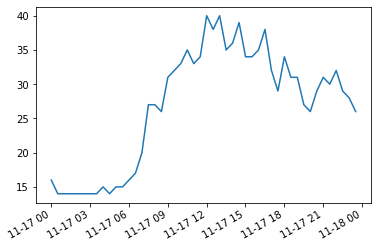

In [311]:
# import matplotlib.pyplot as plt
x = [start_date + dt.timedelta(minutes=i*30) for i in range(48)]
plt.plot(x, combined_df_sorted['lots_available'][48*19:48*20])
plt.gcf().autofmt_xdate()
plt.show()

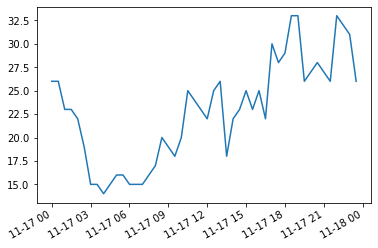

In [312]:
x = [start_date + dt.timedelta(minutes=i*30) for i in range(48)]
plt.plot(x, combined_df_sorted['lots_available'][48*21:48*22])
plt.gcf().autofmt_xdate()
plt.show()

In [313]:
df_list_by_number = [combined_df_sorted[i*1443:(1443*(i+1))].reset_index() for i in range(n_parking_areas)]

In [314]:
# combined_df = pd.read_csv('singapore_parking_data_2019-11-17_000030_to_010030.csv')
# Model and encoding for one whole dataframe
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
n_parking_areas = len(df_list_by_number[0]['carpark_number'].unique())
n_car_park_types = len(df_list_by_number[0]['car_park_type'].unique())
n_unique_month = len(df_list_by_number[0]['month'].unique())
n_unique_days = len(df_list_by_number[0]['day'].unique())
n_unique_hour = len(df_list_by_number[0]['hour'].unique())
n_unique_minute = len(df_list_by_number[0]['minute'].unique())

def normalize(x):
    normalized = (x - x.min()) / (x.max() - x.min())
    return normalized

def normalize(x):
    normalized = (x - x.min()) / (x.max() - x.min())
    return normalized

encoded_minute = preprocessing.LabelEncoder().fit(df_list_by_number[0]['minute'].unique()).transform(df_list_by_number[0]['minute'].to_numpy()[:-1])
encoded_month = preprocessing.LabelEncoder().fit(df_list_by_number[0]['month'].unique()).transform(df_list_by_number[0]['month'].to_numpy()[:-1])
encoded_day = preprocessing.LabelEncoder().fit(df_list_by_number[0]['day'].unique()).transform(df_list_by_number[0]['day'].to_numpy()[:-1])
encoded_hour = preprocessing.LabelEncoder().fit(df_list_by_number[0]['hour'].unique()).transform(df_list_by_number[0]['hour'].to_numpy()[:-1])
availabile = df_list_by_number[0]['lots_available'].to_numpy()
available_normalized = normalize(df_list_by_number[0]['lots_available'].to_numpy())
available_standardized = preprocessing.scale(df_list_by_number[0]['lots_available'].to_numpy())
x = [available_standardized[:-1], encoded_parking_areas, encoded_car_park_types, encoded_hour, encoded_minute]
# y = available_normalized[1:]
y = available_standardized[1:]
# x, x_test, y_train, y_test = train_test_split(np.array(x).T, y, test_size=0.2, random_state=15)
# x = x.T
# x_test = x_test.T
df_list_by_number[0].head()

,index,carpark_number,update_datetime,year,month,day,hour,minute,second,total_lots,lot_type,lots_available,car_park_type,type_of_parking_system
0,0,A10,2019-11-16T23:59:30,2019,11,17,0,0,30,62,C,21,SURFACE CAR PARK,ELECTRONIC PARKING
1,1,A10,2019-11-17T00:29:31,2019,11,17,0,30,30,62,C,19,SURFACE CAR PARK,ELECTRONIC PARKING
2,2,A10,2019-11-17T00:59:32,2019,11,17,1,0,30,62,C,15,SURFACE CAR PARK,ELECTRONIC PARKING
3,3,A10,2019-11-17T01:29:33,2019,11,17,1,30,30,62,C,12,SURFACE CAR PARK,ELECTRONIC PARKING
4,4,A10,2019-11-17T01:59:34,2019,11,17,2,0,30,62,C,11,SURFACE CAR PARK,ELECTRONIC PARKING


In [315]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, Reshape, Flatten
# from tensorflow.keras.layers.core import Dense, Reshape, Lambda
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vacancy_in = Input(shape=(1,))
# Below need embedding layer :(
car_park_type_in = Input(shape=(1,))
month_in = Input(shape=(1,))
day_in = Input(shape=(1,))
hour_in = Input(shape=(1,))
minute_in = Input(shape=(1,))

month_embedding = Embedding(n_unique_month, 64)(month_in)
day_embedding = Embedding(n_unique_days, 64)(day_in)
hour_embedding = Embedding(n_unique_hour, 64)(hour_in)
minute_embedding = Embedding(n_unique_minute, 64, input_length=2)(minute_in)

reshape = Flatten()
combined = Concatenate()([vacancy_in, reshape(month_embedding), reshape(day_embedding), reshape(hour_embedding), reshape(minute_embedding)])
#combined = Concatenate()([reshape(parking_area_embedding), reshape(car_par_type_embedding), reshape(hour_embedding), reshape(minute_embedding)])

hidden_1 = Dense(1024, activation='relu')(combined)
hidden_2 = Dense(512, activation='relu')(hidden_1)
hidden_3 = Dense(256, activation='relu')(hidden_2)
hidden_4 = Dense(10, activation='relu')(hidden_3)
final = Dense(1, activation='linear')(hidden_4)

model = Model(inputs=[vacancy_in, month_in, day_in, hour_in, minute_in],
            outputs=final)
# model = Model(inputs=[parking_area_in, car_park_type_in, hour_in, minute_in],
#             outputs=final)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01), metrics=['accuracy'])
model([x, y])
model.summary()

InvalidArgumentError: indices[2296728,0] = 1591 is not in [0, 2) [Op:ResourceGather]

In [607]:
hist = model.fit(x, y, epochs=1, validation_split=0.0, batch_size=16)

91/91 [==============================] - 0s 3ms/step - loss: 1.1057 - accuracy: 0.0000e+00


In [608]:
from sklearn.metrics import r2_score
r2_score(y, model.predict(x))

-0.00012856777896108618

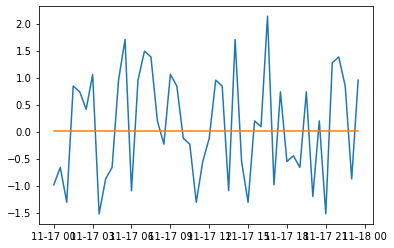

In [609]:
y_day = model.predict(x)[1:49]
x_day = [start_date + dt.timedelta(minutes=i*30) for i in range(48)]
plt.plot(x_day, y[1:49])
plt.plot(x_day, y_day)

In [316]:
#changing x to fit for LSTM
def normalize(data):
    data_mean = data[:].mean(axis=0)
    data_std = data[:].std(axis=0)
    return (data - data_mean) / data_std

available_normalized = normalize(df_list_by_number[2]['lots_available'].to_numpy())
available_standardized = preprocessing.scale(df_list_by_number[2]['lots_available'].to_numpy())
training_split_fraction = 0.8
n_training = int(training_split_fraction * len(df_list_by_number[2]))
n_testing = len(df_list_by_number[2]) - n_training
past = 2
x = []
for i in range(past, len(df_list_by_number[0])):
    x.append(available_normalized[i-past:i])
x = np.array(x[:len(df_list_by_number[2])-past])
x = x.reshape(x.shape[0], x.shape[1], 1)
y = available_normalized[past:]
x_train = x[:n_training]
x_test = x[n_training:]
y_train = y[:n_training]
y_test = y[n_training:]

In [317]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, Reshape, LSTM, SimpleRNN, GRU
from tensorflow.keras import Sequential
# from tensorflow.keras.layers.core import Dense, Reshape, Lambda
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(64, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.3))
# model.add(LSTM(64))
# hidden_2 = Dense(128, activation='relu')(vacancy_dense)
# hidden_3 = Dense(64, activation='relu')(hidden_2)
# hidden_4 = Dense(10, activation='linear')(hidden_3)
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

# model = Model(inputs=[parking_area_in, car_park_type_in, hour_in, minute_in],
#             outputs=final)
model.compile(loss='mae', optimizer=Adam(lr=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 129       
Total params: 25,345
Trainable params: 25,345
Non-trainable params: 0
_________________________________________________________________


In [319]:
hist = model.fit(x_train, y_train, epochs=2000, validation_split=0.0, batch_size=16)

Epoch 1/2000
73/73 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.0000e+00
Epoch 2/2000
73/73 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.0000e+00
Epoch 3/2000
73/73 [==============================] - 0s 5ms/step - loss: 0.1023 - accuracy: 0.0000e+00
Epoch 4/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.1029 - accuracy: 0.0000e+00
Epoch 5/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.0988 - accuracy: 0.0000e+00
Epoch 6/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.1094 - accuracy: 0.0000e+00
Epoch 7/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0937 - accuracy: 0.0000e+00: 0s - loss: 0.0926 - accura
Epoch 8/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.1004 - accuracy: 0.0000e+00: 0s - loss: 0.1013 - ac
Epoch 9/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0926 - accuracy: 0.0000e+00
Epoch 10/200

73/73 [==============================] - 0s 7ms/step - loss: 0.0863 - accuracy: 0.0000e+00
Epoch 152/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0870 - accuracy: 0.0000e+00
Epoch 153/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0873 - accuracy: 0.0000e+00
Epoch 154/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0886 - accuracy: 0.0000e+00
Epoch 155/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0860 - accuracy: 0.0000e+00
Epoch 156/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0836 - accuracy: 0.0000e+00
Epoch 157/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0882 - accuracy: 0.0000e+00
Epoch 158/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0874 - accuracy: 0.0000e+00
Epoch 159/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0869 - accuracy: 0.0000e+00
Epoch 160/2000
73/73 [==============================] - 0s 7m

73/73 [==============================] - 0s 6ms/step - loss: 0.0844 - accuracy: 0.0000e+00
Epoch 304/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0861 - accuracy: 0.0000e+00
Epoch 305/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0874 - accuracy: 0.0000e+00
Epoch 306/2000
73/73 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.0000e+ - 0s 7ms/step - loss: 0.0870 - accuracy: 0.0000e+00
Epoch 307/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0871 - accuracy: 0.0000e+00
Epoch 308/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.0880 - accuracy: 0.0000e+00
Epoch 309/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0827 - accuracy: 0.0000e+00
Epoch 310/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0857 - accuracy: 0.0000e+00
Epoch 311/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.0836 - accuracy: 0.0000e+00
Epoch 312/2000


73/73 [==============================] - 1s 8ms/step - loss: 0.0826 - accuracy: 0.0000e+00
Epoch 377/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0842 - accuracy: 0.0000e+00
Epoch 378/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0860 - accuracy: 0.0000e+00
Epoch 379/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0828 - accuracy: 0.0000e+00
Epoch 380/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0837 - accuracy: 0.0000e+00
Epoch 381/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0836 - accuracy: 0.0000e+00
Epoch 382/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.0854 - accuracy: 0.0000e+00
Epoch 383/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.0842 - accuracy: 0.0000e+00
Epoch 384/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0811 - accuracy: 0.0000e+00
Epoch 385/2000
73/73 [==============================] - 1s 7m

73/73 [==============================] - 1s 7ms/step - loss: 0.0870 - accuracy: 0.0000e+00
Epoch 528/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0812 - accuracy: 0.0000e+00
Epoch 529/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0846 - accuracy: 0.0000e+00
Epoch 530/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0831 - accuracy: 0.0000e+00
Epoch 531/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0825 - accuracy: 0.0000e+00
Epoch 532/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0849 - accuracy: 0.0000e+00
Epoch 533/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0857 - accuracy: 0.0000e+00: 0s - loss: 0.0919 - accu
Epoch 534/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0864 - accuracy: 0.0000e+00
Epoch 535/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0815 - accuracy: 0.0000e+00
Epoch 536/2000
73/73 [=============

73/73 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.0000e+00
Epoch 680/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0826 - accuracy: 0.0000e+00
Epoch 681/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.0828 - accuracy: 0.0000e+00
Epoch 682/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0851 - accuracy: 0.0000e+00
Epoch 683/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.0824 - accuracy: 0.0000e+00
Epoch 684/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0813 - accuracy: 0.0000e+00
Epoch 685/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0787 - accuracy: 0.0000e+00
Epoch 686/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0819 - accuracy: 0.0000e+00
Epoch 687/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.0809 - accuracy: 0.0000e+00
Epoch 688/2000
73/73 [==============================] - 0s 7m

Epoch 755/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.0794 - accuracy: 0.0000e+00
Epoch 756/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.0810 - accuracy: 0.0000e+00
Epoch 757/2000
73/73 [==============================] - 1s 10ms/step - loss: 0.0821 - accuracy: 0.0000e+00
Epoch 758/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0823 - accuracy: 0.0000e+00
Epoch 759/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.0812 - accuracy: 0.0000e+00
Epoch 760/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0794 - accuracy: 0.0000e+00
Epoch 761/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0836 - accuracy: 0.0000e+00
Epoch 762/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0845 - accuracy: 0.0000e+00
Epoch 763/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0845 - accuracy: 0.0000e+00
Epoch 764/2000
73/73 [=======================

Epoch 905/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.0804 - accuracy: 0.0000e+00
Epoch 906/2000
73/73 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.0000e+00
Epoch 907/2000
73/73 [==============================] - 0s 5ms/step - loss: 0.0825 - accuracy: 0.0000e+00
Epoch 908/2000
73/73 [==============================] - 0s 5ms/step - loss: 0.0778 - accuracy: 0.0000e+00
Epoch 909/2000
73/73 [==============================] - 0s 5ms/step - loss: 0.0798 - accuracy: 0.0000e+00
Epoch 910/2000
73/73 [==============================] - 0s 5ms/step - loss: 0.0814 - accuracy: 0.0000e+00
Epoch 911/2000
73/73 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.0000e+00
Epoch 912/2000
73/73 [==============================] - 0s 5ms/step - loss: 0.0808 - accuracy: 0.0000e+00
Epoch 913/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.0808 - accuracy: 0.0000e+00
Epoch 914/2000
73/73 [========================

73/73 [==============================] - 0s 7ms/step - loss: 0.0795 - accuracy: 0.0000e+00
Epoch 982/2000
73/73 [==============================] - 1s 9ms/step - loss: 0.0793 - accuracy: 0.0000e+00
Epoch 983/2000
73/73 [==============================] - 0s 7ms/step - loss: 0.0810 - accuracy: 0.0000e+00
Epoch 984/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0794 - accuracy: 0.0000e+00
Epoch 985/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0815 - accuracy: 0.0000e+00
Epoch 986/2000
73/73 [==============================] - 1s 8ms/step - loss: 0.0795 - accuracy: 0.0000e+00
Epoch 987/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0831 - accuracy: 0.0000e+00
Epoch 988/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0810 - accuracy: 0.0000e+00
Epoch 989/2000
73/73 [==============================] - 1s 7ms/step - loss: 0.0858 - accuracy: 0.0000e+00
Epoch 990/2000
73/73 [==============================] - ETA: 

73/73 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.0000e+00
Epoch 1131/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.0000e+00
Epoch 1132/2000
73/73 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.0000e+00
Epoch 1133/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0808 - accuracy: 0.0000e+00
Epoch 1134/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0785 - accuracy: 0.0000e+00
Epoch 1135/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.0000e+00
Epoch 1136/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.0000e+00
Epoch 1137/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.0000e+00
Epoch 1138/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.0000e+00
Epoch 1139/2000
73/73 [==============================

73/73 [==============================] - 0s 3ms/step - loss: 0.0791 - accuracy: 0.0000e+00
Epoch 1281/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0802 - accuracy: 0.0000e+00
Epoch 1282/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.0000e+00
Epoch 1283/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.0000e+00
Epoch 1284/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0774 - accuracy: 0.0000e+00
Epoch 1285/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0795 - accuracy: 0.0000e+00
Epoch 1286/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0815 - accuracy: 0.0000e+00
Epoch 1287/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0774 - accuracy: 0.0000e+00
Epoch 1288/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0793 - accuracy: 0.0000e+00
Epoch 1289/2000
73/73 [==============================

73/73 [==============================] - 0s 3ms/step - loss: 0.0767 - accuracy: 0.0000e+00
Epoch 1357/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0775 - accuracy: 0.0000e+00
Epoch 1358/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.0000e+00
Epoch 1359/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0808 - accuracy: 0.0000e+00
Epoch 1360/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.0000e+00
Epoch 1361/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0785 - accuracy: 0.0000e+00
Epoch 1362/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0775 - accuracy: 0.0000e+00
Epoch 1363/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0787 - accuracy: 0.0000e+00
Epoch 1364/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.0000e+00
Epoch 1365/2000
73/73 [==============================

73/73 [==============================] - 0s 3ms/step - loss: 0.0800 - accuracy: 0.0000e+00
Epoch 1508/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0820 - accuracy: 0.0000e+00
Epoch 1509/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0764 - accuracy: 0.0000e+00
Epoch 1510/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0814 - accuracy: 0.0000e+00
Epoch 1511/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0748 - accuracy: 0.0000e+00
Epoch 1512/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0778 - accuracy: 0.0000e+00
Epoch 1513/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0758 - accuracy: 0.0000e+00
Epoch 1514/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0787 - accuracy: 0.0000e+00
Epoch 1515/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0793 - accuracy: 0.0000e+00
Epoch 1516/2000
73/73 [==============================

73/73 [==============================] - 0s 3ms/step - loss: 0.0773 - accuracy: 0.0000e+00
Epoch 1659/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0794 - accuracy: 0.0000e+00
Epoch 1660/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0760 - accuracy: 0.0000e+00
Epoch 1661/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0783 - accuracy: 0.0000e+00
Epoch 1662/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0766 - accuracy: 0.0000e+00
Epoch 1663/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.0000e+00
Epoch 1664/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0776 - accuracy: 0.0000e+00
Epoch 1665/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0771 - accuracy: 0.0000e+00
Epoch 1666/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0771 - accuracy: 0.0000e+00
Epoch 1667/2000
73/73 [==============================

73/73 [==============================] - 0s 3ms/step - loss: 0.0788 - accuracy: 0.0000e+00
Epoch 1809/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0776 - accuracy: 0.0000e+00
Epoch 1810/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.0000e+00
Epoch 1811/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.0000e+00
Epoch 1812/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0759 - accuracy: 0.0000e+00
Epoch 1813/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0759 - accuracy: 0.0000e+00
Epoch 1814/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0783 - accuracy: 0.0000e+00
Epoch 1815/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0753 - accuracy: 0.0000e+00
Epoch 1816/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.0000e+00
Epoch 1817/2000
73/73 [==============================

73/73 [==============================] - 0s 3ms/step - loss: 0.0751 - accuracy: 0.0000e+00
Epoch 1885/2000
73/73 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.0000e+ - 0s 3ms/step - loss: 0.0736 - accuracy: 0.0000e+00
Epoch 1886/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0774 - accuracy: 0.0000e+00
Epoch 1887/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.0000e+00
Epoch 1888/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0747 - accuracy: 0.0000e+00
Epoch 1889/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0761 - accuracy: 0.0000e+00
Epoch 1890/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0773 - accuracy: 0.0000e+00
Epoch 1891/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0763 - accuracy: 0.0000e+00
Epoch 1892/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.0758 - accuracy: 0.0000e+00
Epoch 1

In [306]:
from sklearn.metrics import r2_score
r2_score(y_test[:-1] - y_test[1:], model.predict(x_test)[:-1] - model.predict(x_test)[1:])

-0.779892746856031

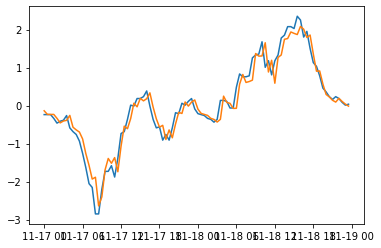

In [307]:
import matplotlib.pyplot as plt
y_day = model.predict(x_train)[0:96]
x_day = [start_date + dt.timedelta(minutes=i*30) for i in range(96)]
plt.plot(x_day, y_train[0:96])
plt.plot(x_day, y_day)

In [273]:
#changing x to fit for LSTM
from keras import backend as K
def normalize(data):
    data_mean = data[:].mean(axis=0)
    data_std = data[:].std(axis=0)
    return (data - data_mean) / data_std

available_normalized = normalize(df_list_by_number[2]['lots_available'].to_numpy())
available_standardized = preprocessing.scale(df_list_by_number[2]['lots_available'].to_numpy())
training_split_fraction = 0.8
n_training = int(training_split_fraction * len(df_list_by_number[2]))
n_testing = len(df_list_by_number[2]) - n_training
past = 2
encoded_minute = preprocessing.LabelEncoder().fit(df_list_by_number[2]['minute'].unique()).transform(df_list_by_number[2]['minute'].to_numpy()[past:])
encoded_month = preprocessing.LabelEncoder().fit(df_list_by_number[2]['month'].unique()).transform(df_list_by_number[2]['month'].to_numpy()[past:])
encoded_day = preprocessing.LabelEncoder().fit(df_list_by_number[2]['day'].unique()).transform(df_list_by_number[2]['day'].to_numpy()[past:])
encoded_hour = preprocessing.LabelEncoder().fit(df_list_by_number[2]['hour'].unique()).transform(df_list_by_number[2]['hour'].to_numpy()[past:])

available = []
for i in range(past, len(df_list_by_number[2])):
    available.append(available_normalized[i-past:i])
available = np.array(available[:len(df_list_by_number[2])-past])
available = available.reshape(available.shape[0], available.shape[1], 1)

x = []
for i in range(0, len(df_list_by_number[2])-past):
    x.append([available[i-past], encoded_month[i], encoded_day[i], encoded_hour[i], encoded_minute[i]])
x = np.hstack(x)
x = np.asarray(x).astype(np.float32)
x = x[:len(df_list_by_number[2])-past]
y = available_normalized[past:]
x_train = x[:n_training]
x_test = x[n_training:]
y_train = y[:n_training]
y_test = y[n_training:]

ValueError: setting an array element with a sequence.

In [262]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, Reshape, LSTM, SimpleRNN, GRU
from tensorflow.keras import Sequential
# from tensorflow.keras.layers.core import Dense, Reshape, Lambda
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vacancy_in = Input(shape=(x[0][0].shape[1], 1))
rnn_1 = LSTM(64, return_sequences=True)(vacancy_in)
rnn_2 = LSTM(32)(rnn_1)

car_park_type_in = Input(shape=(1,))
month_in = Input(shape=(1,))
day_in = Input(shape=(1,))
hour_in = Input(shape=(1,))
minute_in = Input(shape=(1,))

month_embedding = Embedding(n_unique_month, 64)(month_in)
day_embedding = Embedding(n_unique_days, 64)(day_in)
hour_embedding = Embedding(n_unique_hour, 64)(hour_in)
minute_embedding = Embedding(n_unique_minute, 64, input_length=2)(minute_in)

reshape = Flatten()
combined = Concatenate()([rnn_2, reshape(month_embedding), reshape(day_embedding), reshape(hour_embedding), reshape(minute_embedding)])
hidden = Dense(32, activation='relu')(combined)
final = Dense(1, activation='linear')(hidden)
# hidden_2 = Dense(128, activation='relu')(vacancy_dense)
# hidden_3 = Dense(64, activation='relu')(hidden_2)
# hidden_4 = Dense(10, activation='linear')(hidden_3)
model = Model(inputs=[vacancy_in, month_in, day_in, hour_in, minute_in],
            outputs=[final])
# model = Model(inputs=[parking_area_in, car_park_type_in, hour_in, minute_in],
#             outputs=final)
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_87 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_88 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________

In [263]:
hist = model.fit(x_train, y_train, epochs=2000, validation_split=0.0, batch_size=16)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [87]:
combined_df_sorted['car_park_type'].unique()

array(['SURFACE CAR PARK', 'MULTI-STOREY CAR PARK', 'BASEMENT CAR PARK',
       'MECHANISED CAR PARK', 'COVERED CAR PARK',
       'MECHANISED AND SURFACE CAR PARK'], dtype=object)

In [283]:
df_list_by_number[2]

,index,carpark_number,update_datetime,year,month,day,hour,minute,second,total_lots,lot_type,lots_available,car_park_type,type_of_parking_system
0,2886,A11,2019-12-04T21:59:35,2019,12,4,22,0,30,368,C,178,SURFACE CAR PARK,ELECTRONIC PARKING
1,2887,A11,2019-12-07T10:29:31,2019,12,7,10,30,30,368,C,115,SURFACE CAR PARK,ELECTRONIC PARKING
2,2888,A11,2019-11-27T14:59:38,2019,11,27,15,0,30,368,C,257,SURFACE CAR PARK,ELECTRONIC PARKING
3,2889,A11,2019-12-09T03:59:39,2019,12,9,4,0,30,368,C,169,SURFACE CAR PARK,ELECTRONIC PARKING
4,2890,A11,2019-12-01T23:59:49,2019,12,2,0,0,30,368,C,186,SURFACE CAR PARK,ELECTRONIC PARKING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,4324,A11,2019-12-16T09:59:30,2019,12,16,10,0,30,368,C,271,SURFACE CAR PARK,ELECTRONIC PARKING
1439,4325,A11,2019-12-04T07:00:03,2019,12,4,7,0,30,368,C,157,SURFACE CAR PARK,ELECTRONIC PARKING
1440,4326,A11,2019-11-27T06:59:30,2019,11,27,7,0,30,368,C,165,SURFACE CAR PARK,ELECTRONIC PARKING
1441,4327,A11,2019-11-28T07:59:35,2019,11,28,8,0,30,368,C,165,SURFACE CAR PARK,ELECTRONIC PARKING
